# Tarea Semanal 5: Filtrado digital lineal de ECG

##### Florencia Alvarez

Usando el archivo ecg.mat que contiene un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

Archivo ECG.mat (variables)

- ecg_lead: Registro de ECG muestreado a f s igual 1  KHz durante una prueba de esfuerzo
- qrs_pattern1: Complejo de ondas QRS normal
- heartbeat_pattern1: Latido normal
- heartbeat_pattern2: Latido de origen ventricular
- qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos

Se pide:

a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.

b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.

c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.

Ayuda: Para los filtros IIR adopte las aproximaciones de módulo de máxima planicidad, Chebyshev y Cauer. Para los FIR, utilice las metodologías de ventanas, cuadrados mínimos y Parks-Mc Clellan-Remez. Todos implementados en SciPy.Signal

d)  Evalúe el rendimiento de los filtros que haya diseñado:

Verifique que filtra las señales interferentes.
Verifique que es inocuo en las zonas donde no hay interferentes.

### Introducción

El objetivo de este trabajo es analizar una señal ECG, tanto sin ruido como su versión contaminada con ruido de baja frecuencia (producido por la respiración) y de alta frecuencia (producido por el movimiento de los electrodos y el ruido muscular).

A continuación, se deberán diseñar e implementar distintos tipos de filtros digitales lineales para atenuar estas componentes indeseadas. Para ello, se diseñó una plantilla adecuada a partir del análisis de la densidad espectral de potencia (PSD) de la señal, estableciendo las frecuencias de paso y de stop del filtro pasabanda.

### Codigo de Python

In [20]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio

#### ECG sin ruido

Ancho de banda del ECG sin ruido (99% potencia): 30.0 Hz


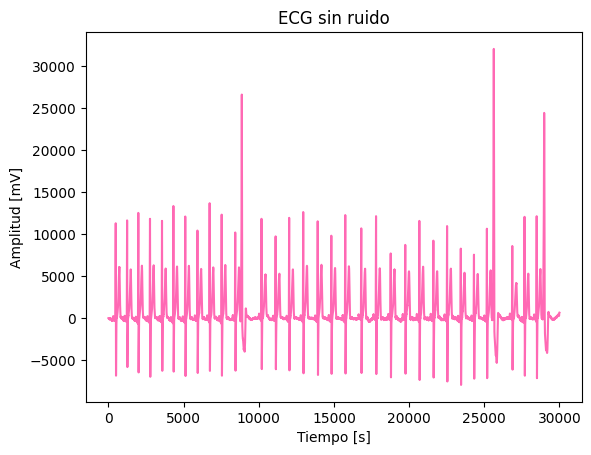

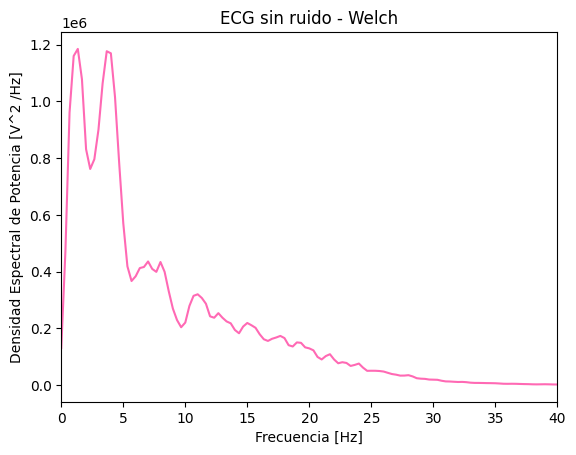

In [21]:
##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Hz

##################
## ECG sin ruido
##################

ecg_one_lead = np.load('ecg_sin_ruido.npy')
N = len(ecg_one_lead)

plt.figure()
plt.plot(ecg_one_lead, color='hotpink')
plt.title('ECG sin ruido')
plt.xlabel('Tiempo [s]') 
plt.ylabel('Amplitud [mV]') 

fw, pw= sig.welch(ecg_one_lead, fs= fs_ecg, window='flattop', nperseg=N/10) #Welch te devuelve la densidad espectral de potencia

plt.figure() 
plt.plot(fw,pw, color='hotpink') 
#plt.plot(fw, 20*np.log10(np.abs(pw)), color='crimson')  #Para ver lo de lo 40db que caen
plt.xlim(0, 40) # Limita el eje x
plt.title('ECG sin ruido - Welch') 
plt.xlabel('Frecuencia [Hz]') 
plt.ylabel('Densidad Espectral de Potencia [V^2 /Hz]') 

pot_acum = np.cumsum(pw) * (fw[1]-fw[0])  # Cumsum te hace la integral. Hay que multiplicarlo por un diferencial delta f para ir acumulando
pot_total = pot_acum[-1]                  # Cuando pones el [-1] te devuelve la potencia del ultimo valor y como estoy usando la potencia acumulada seria mi potencia total
 
idx = np.where(pot_acum >= 0.99 * pot_total)[0][0] # Return elements chosen from x or y depending on condition. Te arma un vector que te dice si se cumple o no la condicion Me devuelve el primer valor donde se cumple esta condicion
bw = fw[idx] # Me fijo a que frecuencia corresponde el valor
print("Ancho de banda del ECG sin ruido (99% potencia):", bw, "Hz")

#### ECG con ruido

Ancho de banda del ECG con ruido (99% potencia): 32.628334573280895 Hz


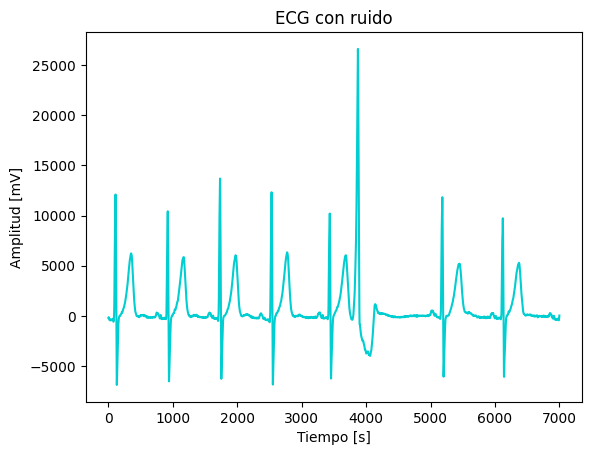

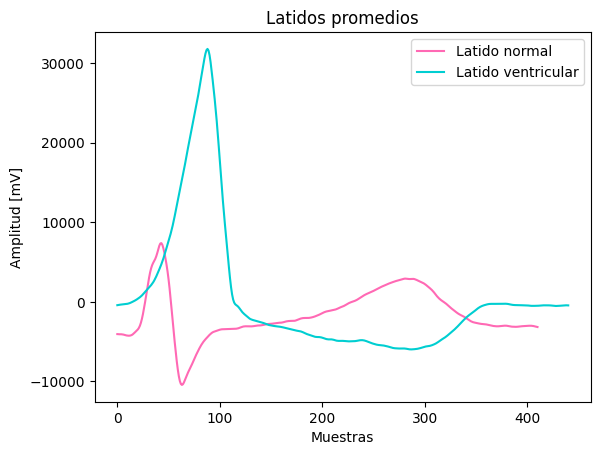

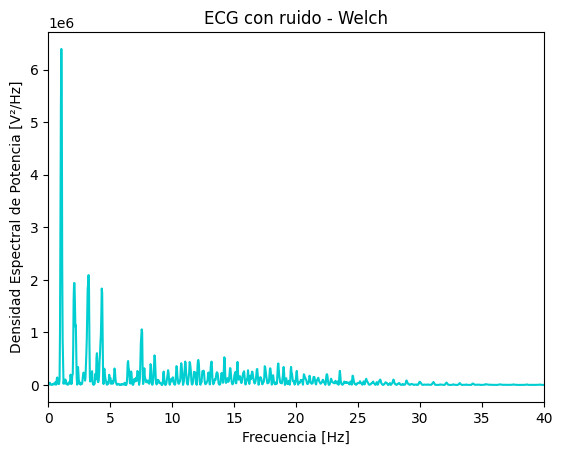

In [22]:
##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecgR_one_lead = mat_struct['ecg_lead'].flatten()
N = len(ecgR_one_lead)
hb_1 = mat_struct['heartbeat_pattern1']
hb_2 = mat_struct['heartbeat_pattern2']

plt.figure()
plt.plot(ecg_one_lead[5000:12000], color='darkturquoise')
plt.title('ECG con ruido')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [mV]')

plt.figure()
plt.plot(hb_1, label='Latido normal', color='hotpink')
plt.plot(hb_2, label='Latido ventricular', color='darkturquoise')
plt.title('Latidos promedios')
plt.xlabel('Muestras')
plt.ylabel('Amplitud [mV]')
plt.legend()

# Welch
fw_ecgR, pw_ecgR = sig.welch(ecg_one_lead, fs=fs_ecg, window='flattop', nperseg=N/40)

plt.figure()
plt.plot(fw_ecgR, pw_ecgR, color='darkturquoise')
plt.xlim(0, 40)
plt.title('ECG con ruido - Welch')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad Espectral de Potencia [V²/Hz]')

# Potencia acumulada
pot_acum_ecgR = np.cumsum(pw_ecgR) * (fw_ecgR[1] - fw_ecgR[0])
pot_total_ecgR = pot_acum_ecgR[-1]

# Frecuencia donde se acumula el 99% de la potencia
idx_ecgR = np.where(pot_acum_ecgR >= 0.99 * pot_total_ecgR)[0][0]
bw_ecgR = fw_ecgR[idx_ecgR]

print("Ancho de banda del ECG con ruido (99% potencia):", bw_ecgR, "Hz")

#### Regiones de interés

In [23]:
regs_interes = (
        np.array([5, 5.2]) *60*fs_ecg, # minutos a muestras
        np.array([12, 12.4]) *60*fs_ecg, # minutos a muestras
        np.array([15, 15.2]) *60*fs_ecg, # minutos a muestras
        )

#### Diseño de la plantilla

In [24]:
nyq_frec = fs_ecg / 2
ripple = 1      # dB
atenuacion = 40 # dB

ws1 = 0.2
wp1 = 0.6
wp2 = 30
ws2 = 40

frecs = np.array([0.0, ws1, wp1, wp2, ws2, nyq_frec]) / nyq_frec #Normalizo las frecuencias para usarlas en iirdesign
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

wp = [wp1 / nyq_frec, wp2 / nyq_frec]
ws = [ws1 / nyq_frec, ws2 / nyq_frec]

wp_hpf = wp1 / nyq_frec
ws_hpf = ws1 / nyq_frec

wp_lpf = wp2 / nyq_frec
ws_lpf = ws2 / nyq_frec

#### Filtros IIR

Se comenzó diseñando filtros IIR (respuesta infinita al impulso) que se caracterizan por ser de menor orden que los filtros FIR para cumplir con una misma plantilla de diseño.  Además, su respuesta en frecuencia es más selectiva, por lo que presentan transiciones más angostas entre la banda de paso y la de stop. Esto los convierte en una buena alternatica para atenuar ruido de alta y baja frecuencia.
Sin embargo, este tipo de filtros presentan una fase no lineal, es decir que la señal sufre un retardo. Para prevenirlo, se debe implementar un filtro bidireccional utilizando la función sosfiltfilt, en lugar de sosfilt. De esta forma se logra "cancelar" el retardo producido, obteniendo una señal con desfasaje nulo.

#### Diagrama de polos y ceros de los filtros IIR

In [25]:
def pzmap(z, p, k=1, title='Diagrama de Polos y Ceros'):
    """Grafica el diagrama de polos y ceros en el plano Z."""
    plt.figure(figsize=(5,5))

    # Círculo unidad
    ang = np.linspace(0, 2*np.pi, 200)
    plt.plot(np.cos(ang), np.sin(ang), 'k--', linewidth=1)

    # Zeros y Polos
    if z is not None:
        plt.scatter(np.real(z), np.imag(z), marker='o', facecolors='none',
                    edgecolors='darkturquoise', label='Ceros')
    if p is not None:
        plt.scatter(np.real(p), np.imag(p), marker='x', color='hotpink', label='Polos')

    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.xlabel('Parte real')
    plt.ylabel('Parte imaginaria')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')

##### Butterworth

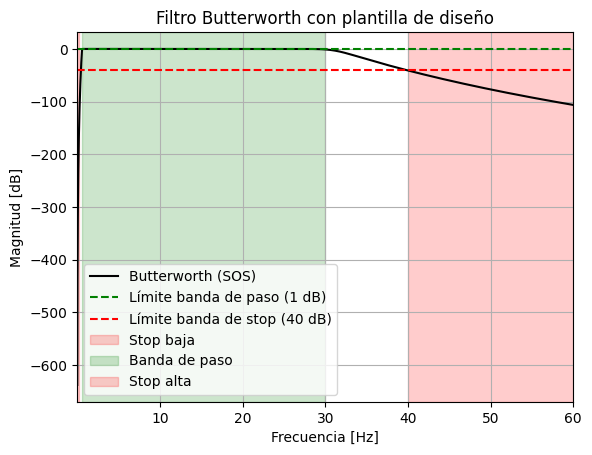

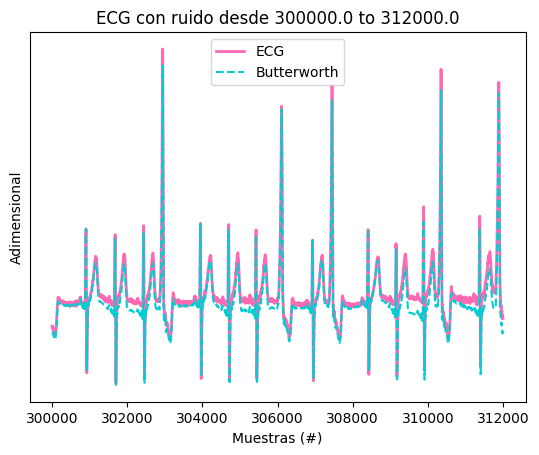

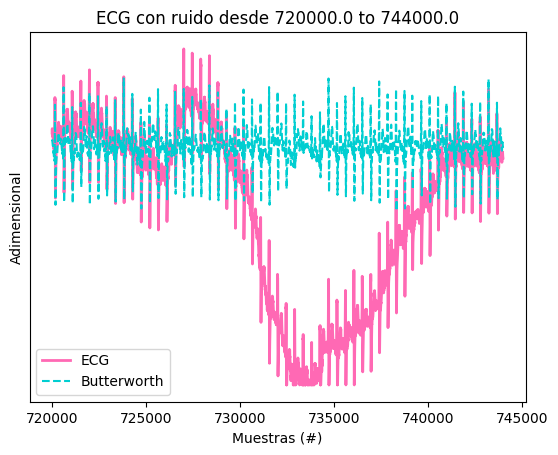

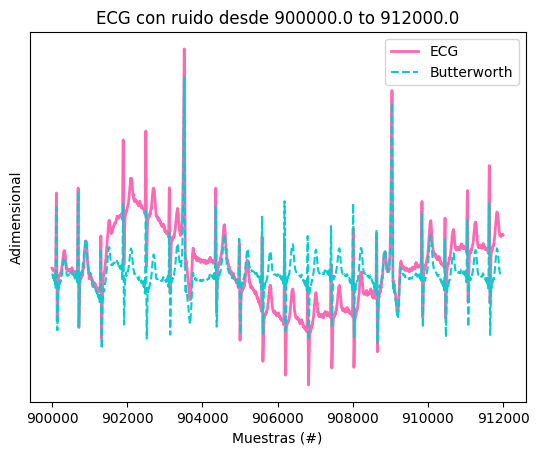

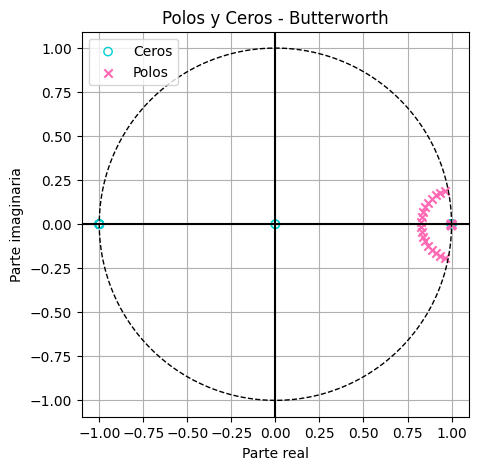

In [29]:
# Armo el filtro Butterworth
sos_b = sig.iirdesign(wp, ws, gpass=ripple, gstop=atenuacion, ftype='butter', output='sos')
w, h = sig.sosfreqz(sos_b, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)

# Plantilla + Bode
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)), color="black", label='Butterworth (SOS)')
plt.axhline(-ripple, color='green', linestyle='--', label=f'Límite banda de paso ({ripple} dB)') #axhline es para marcar los limites en db (1db para el ripple y 40db para la atenuacion)
plt.axhline(-atenuacion, color='red', linestyle='--', label=f'Límite banda de stop ({atenuacion} dB)')

plt.axvspan(0, ws1, color='red', alpha=0.2, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.2, label='Banda de paso')
plt.axvspan(ws2, fs_ecg / 2.0, color='red', alpha=0.2, label='Stop alta')
plt.title('Filtro Butterworth con plantilla de diseño')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0.01, 60)
plt.grid(which='both')
plt.legend()
plt.show()

ecg_b = sig.sosfiltfilt(sos_b, ecgR_one_lead) # Aplico filtro Butterworth
cant_muestras = len(ecgR_one_lead)

for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_b[zoom_region], label='Butterworth', linestyle='--', color = 'darkturquoise')
    
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

z_b, p_b, k = sig.sos2zpk(sos_b) #Butterworth
pzmap(z_b, p_b, title='Polos y Ceros - Butterworth')

##### Chebyshev tipo I

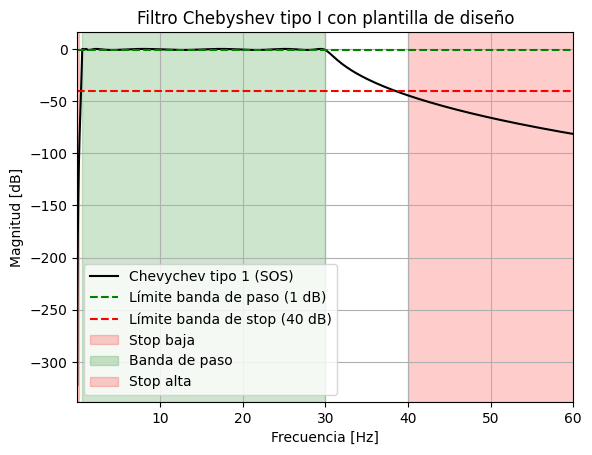

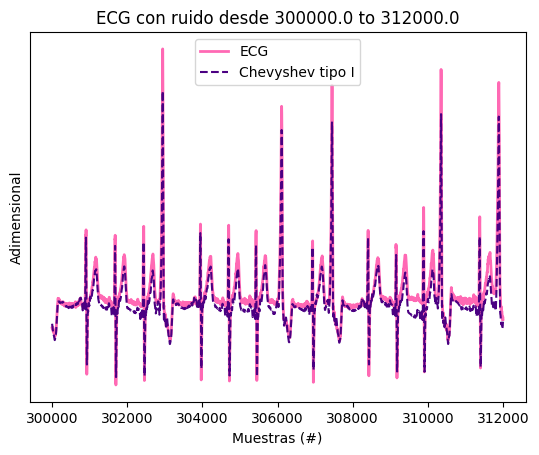

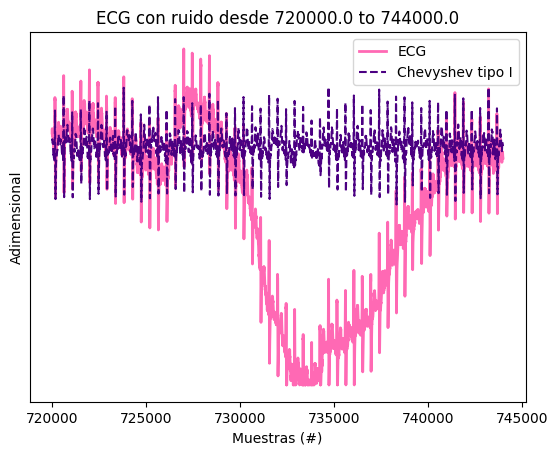

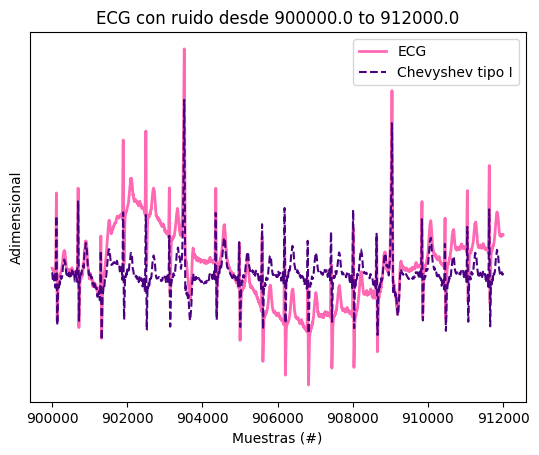

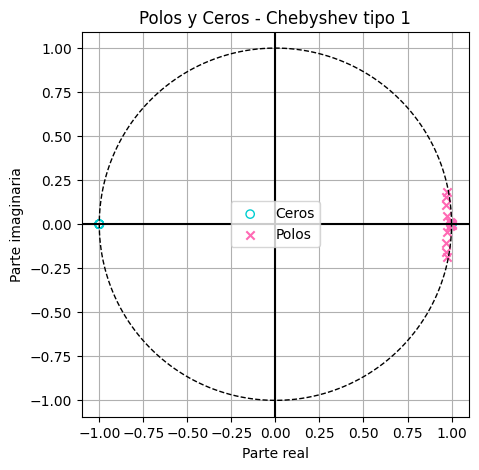

In [30]:
# Armo el filtro Chebyshev tipo 1
sos_c1 = sig.iirdesign(wp, ws, gpass=ripple, gstop=atenuacion, ftype='cheby1', output='sos')
w, h = sig.sosfreqz(sos_c1, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)

# Plantilla + Bode
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)), color="black", label='Chevychev tipo 1 (SOS)')
plt.axhline(-ripple, color='green', linestyle='--', label=f'Límite banda de paso ({ripple} dB)') #axhline es para marcar los limites en db (1db para el ripple y 40db para la atenuacion)
plt.axhline(-atenuacion, color='red', linestyle='--', label=f'Límite banda de stop ({atenuacion} dB)')

plt.axvspan(0, ws1, color='red', alpha=0.2, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.2, label='Banda de paso')
plt.axvspan(ws2, fs_ecg / 2.0, color='red', alpha=0.2, label='Stop alta')

plt.title('Filtro Chebyshev tipo I con plantilla de diseño')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0.01, 60)
plt.grid(which='both')
plt.legend()
plt.show()

ecg_c1 = sig.sosfiltfilt(sos_c1, ecgR_one_lead) # Aplico filtro Chevyshev tipo 1

for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_c1[zoom_region], label='Chevyshev tipo I', linestyle='--', color= 'indigo')
    
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

z_c1, p_c1, k = sig.sos2zpk(sos_c1) #Chebyshev tipo 1
pzmap(z_c1, p_c1, title='Polos y Ceros - Chebyshev tipo 1')

##### Chebyshev tipo II

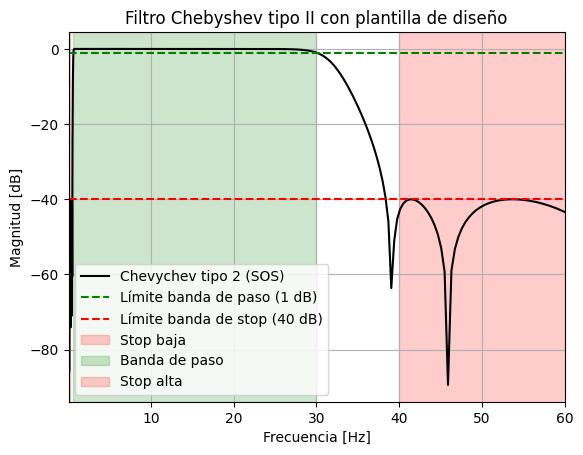

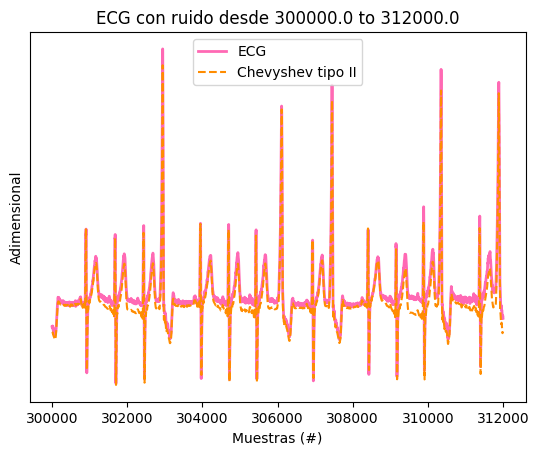

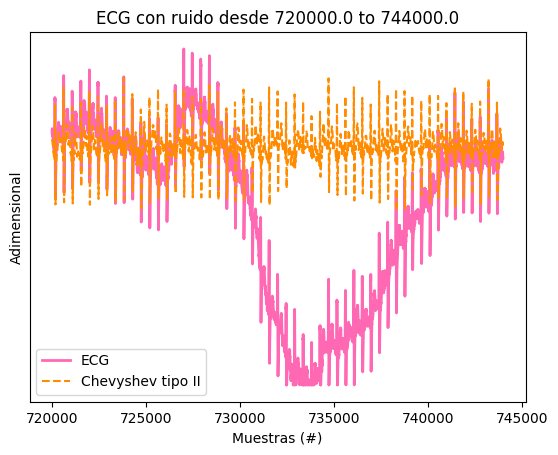

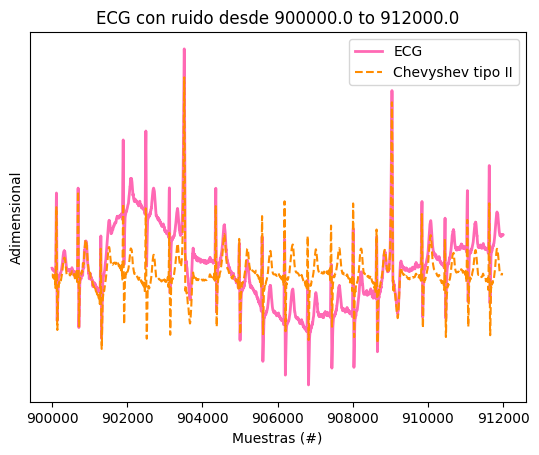

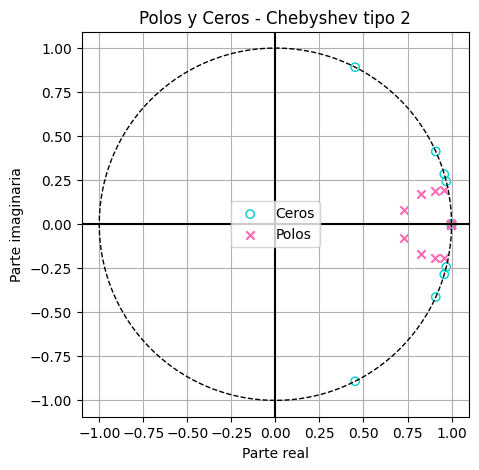

In [31]:
# Armo el filtro Chebyshev tipo 2
sos_c2 = sig.iirdesign(wp, ws, gpass=ripple, gstop=atenuacion, ftype='cheby2', output='sos')
w, h = sig.sosfreqz(sos_c2, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)

# Plantilla + Bode
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)), color="black", label='Chevychev tipo 2 (SOS)')
plt.axhline(-ripple, color='green', linestyle='--', label=f'Límite banda de paso ({ripple} dB)') #axhline es para marcar los limites en db (1db para el ripple y 40db para la atenuacion)
plt.axhline(-atenuacion, color='red', linestyle='--', label=f'Límite banda de stop ({atenuacion} dB)')

# Bandas de la plantilla: axvspan te colorea las bandas de paso y de stop
plt.axvspan(0, ws1, color='red', alpha=0.2, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.2, label='Banda de paso')
plt.axvspan(ws2, fs_ecg / 2.0, color='red', alpha=0.2, label='Stop alta')

plt.title('Filtro Chebyshev tipo II con plantilla de diseño')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0.01, 60)
plt.grid(which='both')
plt.legend()
plt.show()

ecg_c2 = sig.sosfiltfilt(sos_c2, ecgR_one_lead) # Aplico filtro Chevyshev tipo 2

for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_c2[zoom_region], label='Chevyshev tipo II',linestyle='--', color= 'darkorange')
    
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

z_c2, p_c2, k = sig.sos2zpk(sos_c2)  #Chebyshev tipo 2
pzmap(z_c2, p_c2, title='Polos y Ceros - Chebyshev tipo 2')

##### Cauer

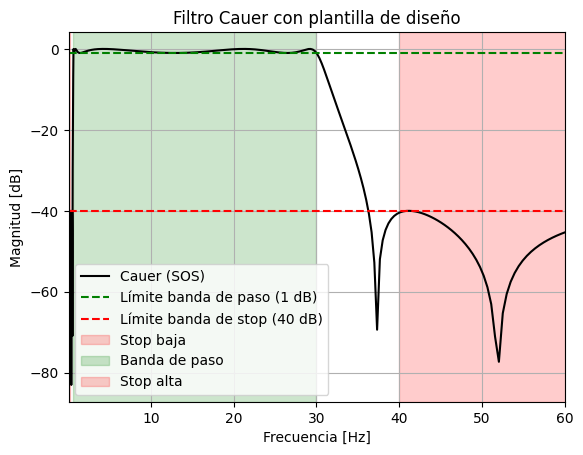

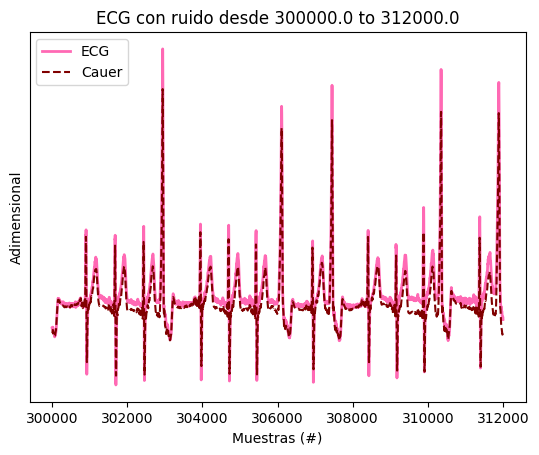

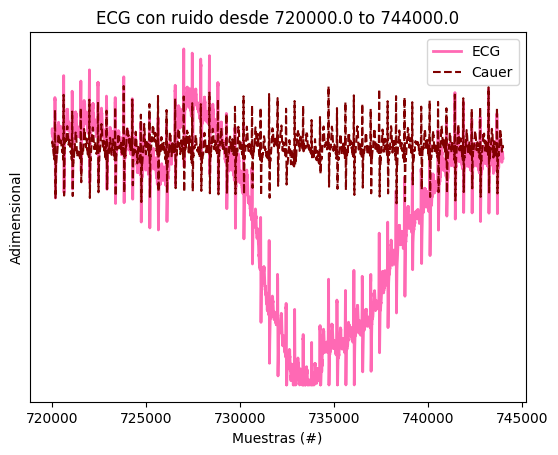

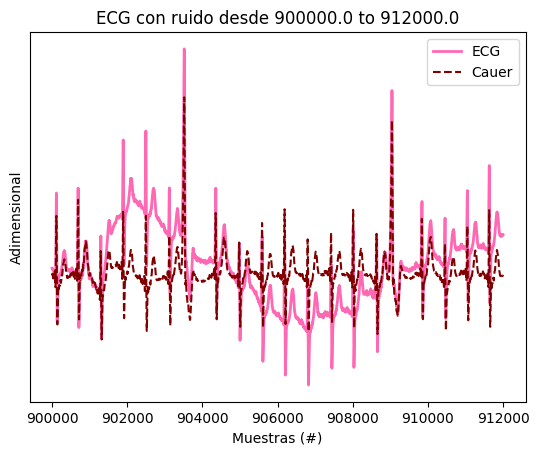

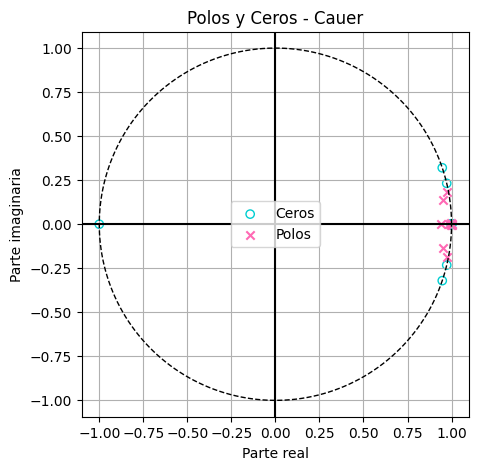

In [32]:
# Armo el filtro Cauer
sos_c = sig.iirdesign(wp, ws, gpass=ripple, gstop=atenuacion, ftype='ellip', output='sos')
w, h = sig.sosfreqz(sos_c, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)

# Plantilla + Bode
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)), color="black", label='Cauer (SOS)')
plt.axhline(-ripple, color='green', linestyle='--', label=f'Límite banda de paso ({ripple} dB)') #axhline es para marcar los limites en db (1db para el ripple y 40db para la atenuacion)
plt.axhline(-atenuacion, color='red', linestyle='--', label=f'Límite banda de stop ({atenuacion} dB)')

# Bandas de la plantilla: axvspan te colorea las bandas de paso y de stop
plt.axvspan(0, ws1, color='red', alpha=0.2, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.2, label='Banda de paso')
plt.axvspan(ws2, fs_ecg / 2.0, color='red', alpha=0.2, label='Stop alta')

plt.title('Filtro Cauer con plantilla de diseño')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0.01, 60)
plt.grid(which='both')
plt.legend()
plt.show()

ecg_c = sig.sosfiltfilt(sos_c, ecgR_one_lead) # Aplico filtro Chevyshev tipo 2

for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_c[zoom_region], label='Cauer',linestyle='--', color= 'maroon')
    
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

z_c, p_c, k = sig.sos2zpk(sos_c)  #Cauer
pzmap(z_c, p_c, title='Polos y Ceros - Cauer')

#### Filtros FIR

Luego se diseñaron e implementaron una serie de filtros FIR que, a diferencia de los IIR, requieren de un orden considerablemente mayor para lograr cumplir con la plantilla, especialmente cuando se busca una transición angosta entre la banda de paso y la de stop.

Además, fue debió pre-distorsionar la plantilla volviéndola más exigente para poder obtener la respuesta en frecuencia deseada.

Por otra parte, los filtros FIR se caracterizan por ser estables siempre y poseer un retardo constante asociado a su fase lineal que debe ser considerado al momento de analizar la señal filtrada.


##### Diagrama de polos y ceros de los filtros FIR

In [36]:
def pzmap_fir(h, title="Polos y Ceros FIR"):
    # NUM = h ; DEN = [1]
    z, p, k = sig.tf2zpk(h, [1])

    plt.figure(figsize=(6,6))

    # Círculo unitario
    ang = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(ang), np.sin(ang), 'k--')

    # Ceros (muchos)
    plt.scatter(np.real(z), np.imag(z),
                c='darkturquoise', marker='o', facecolors='none', label='Ceros')

    # Polos (solo uno: 0)
    plt.scatter(np.real(p), np.imag(p),
                c='hotpink', marker='x', s=80, label='Polos')

    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

    plt.title(title)
    plt.xlabel("Parte real")
    plt.ylabel("Parte imaginaria")
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

##### Ventana rectangular

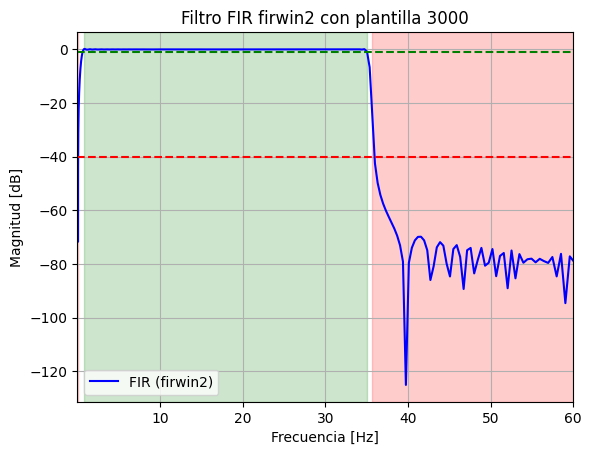

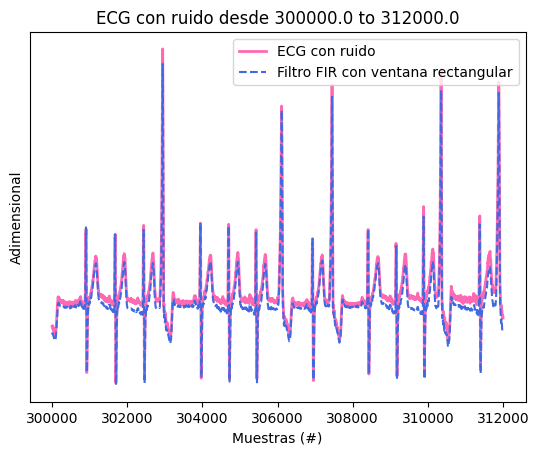

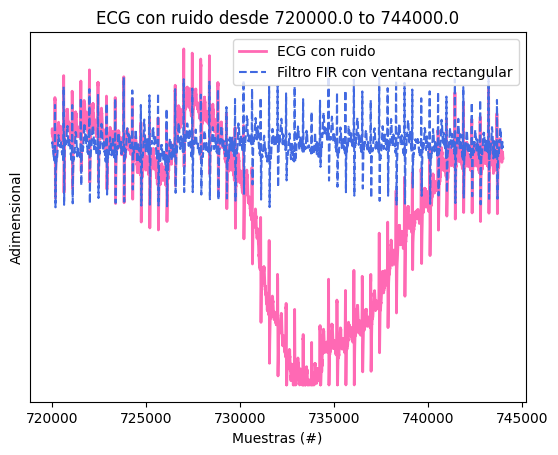

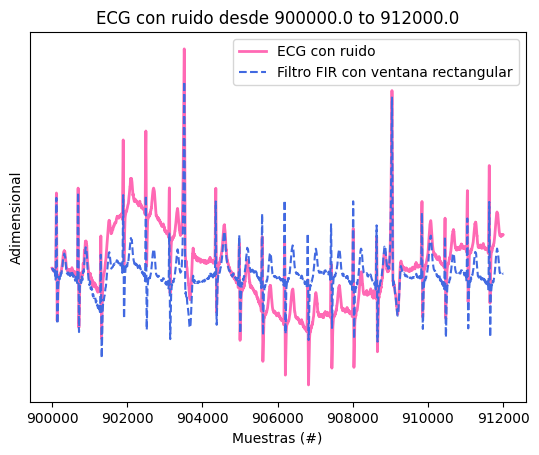

C:\Users\HP\AppData\Local\Temp\ipykernel_3180\2261436174.py:12: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(np.real(z), np.imag(z),


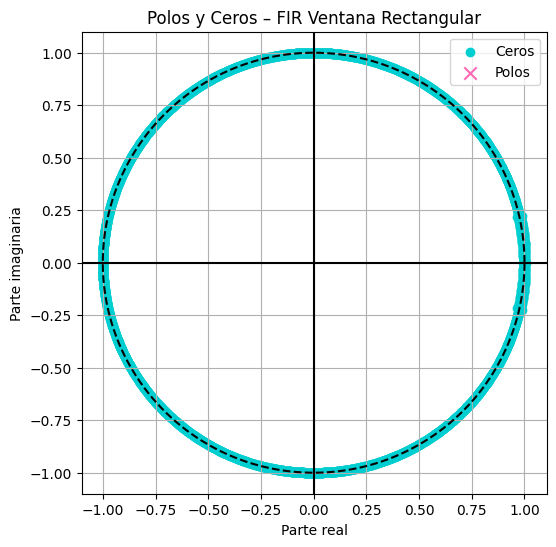

In [37]:
# Predistorsión
ws1_pd = 0.15
wp1_pd = 0.7
wp2_pd = 35
ws2_pd = 35.7

# Plantilla original
ws1 = 0.1
wp1 = 0.8
wp2 = 35
ws2 = 35.7

frecs = np.array([0.0, ws1_pd, wp1_pd, wp2_pd, ws2_pd, nyq_frec])
gains_fir     = np.array([0,   0,   1,   1,   0, 0])
numtaps_firwin=3000

# Diseño el filtro con ventana rectanglar
fir_fil = sig.firwin2( numtaps = numtaps_firwin, freq=frecs, gain=gains_fir, fs=fs_ecg, window='boxcar') #Rectangular porque es la que transiciona más rápido

# Respuesta en frecuencia del FIR
w_fir, h_fir = sig.freqz(fir_fil, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)

# Grafico de plantilla + Bode
plt.figure()
plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), color='blue', label='FIR (firwin2)')
plt.axhline(-ripple, color='green', linestyle='--')
plt.axhline(-atenuacion, color='red', linestyle='--')

plt.axvspan(0, ws1, color='red', alpha=0.2)
plt.axvspan(wp1, wp2, color='green', alpha=0.2)
plt.axvspan(ws2, fs_ecg/2, color='red', alpha=0.2)
plt.title(f'Filtro FIR firwin2 con plantilla {numtaps_firwin}')
plt.xlim(0.01, 60)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()
plt.legend()
plt.show()

ecg_fir = sig.lfilter(fir_fil, 1, ecgR_one_lead) # Aplico el filtro

# Retardo
retardo_fir_fil = (len(fir_fil) - 1)//2

for ii in regs_interes:
   
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG con ruido', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_fir[zoom_region + retardo_fir_fil], label='Filtro FIR con ventana rectangular', linestyle='--',color= 'royalblue')
     
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

# Diagrama de polos y ceros
pzmap_fir(fir_fil, "Polos y Ceros – FIR Ventana Rectangular")


##### Método de cuadrados mínimos

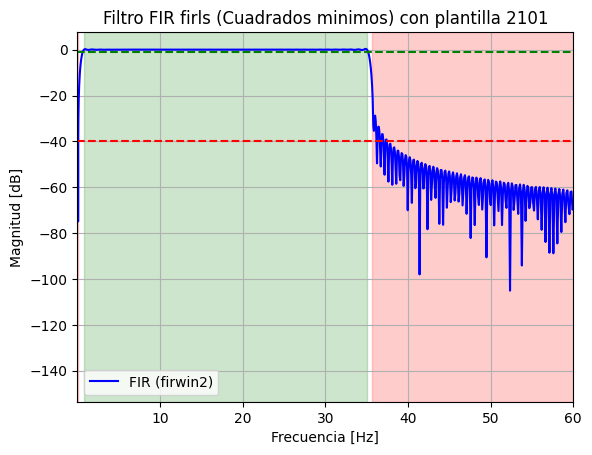

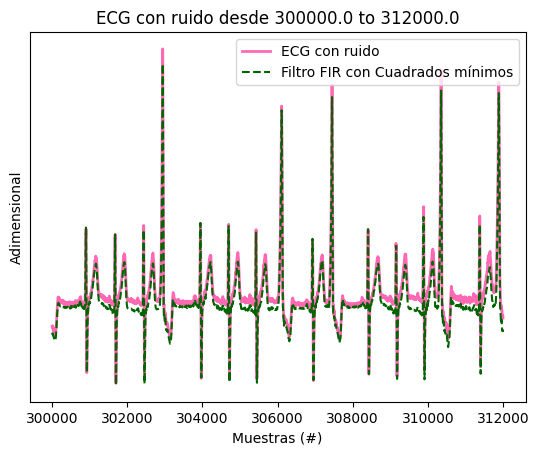

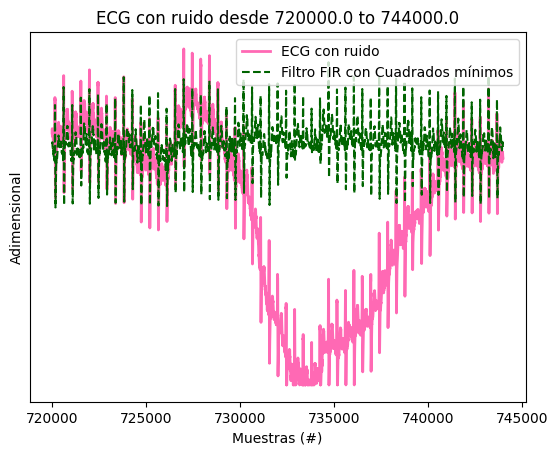

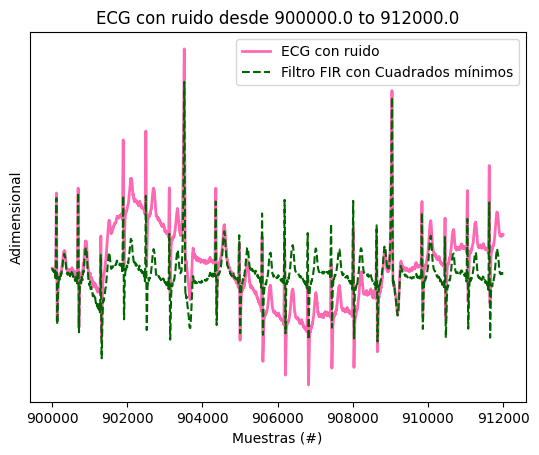

C:\Users\HP\AppData\Local\Temp\ipykernel_3180\2261436174.py:12: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(np.real(z), np.imag(z),


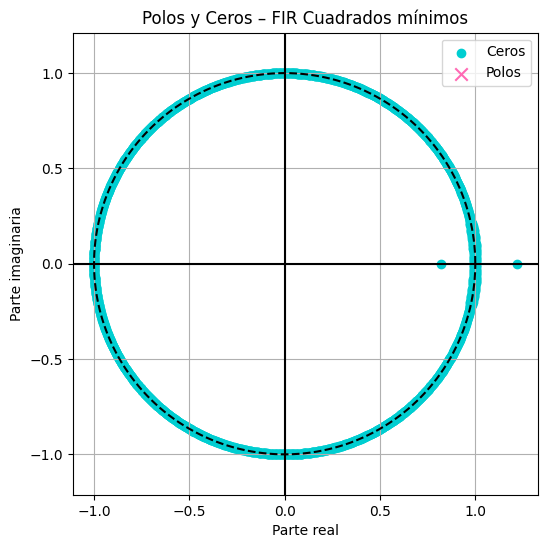

In [38]:
# Predistorsión

ws1_pd = 0.2
wp1_pd = 0.7
wp2_pd = 35.2
ws2_pd = 35.7

# Plantilla original

ws1 = 0.1
wp1 = 0.8
wp2 = 35
ws2 = 35.7

frecs = np.array([0.0, ws1_pd, wp1_pd, wp2_pd, ws2_pd, nyq_frec])
gains_fir     = np.array([0,   0,   1,   1,   0, 0])
numtaps_firls=2101

fir_cuadmin = sig.firls(numtaps=numtaps_firls, bands= frecs, desired= gains_fir, weight=None, fs=fs_ecg)

w_rad = np.append(np.logspace(-3, 0.8, 1000), np.logspace(0.9, 1.8, 1000) )
w_rad = np.append(w_rad, np.linspace(64, nyq_frec, 1000, endpoint=True) )

# Respuesta en frecuencia del FIR
w_fir, h_fir = sig.freqz(fir_cuadmin, worN=w_rad, fs=fs_ecg)

# Gráfico
plt.figure()
plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), color='blue', label='FIR (firwin2)')
plt.axhline(-ripple, color='green', linestyle='--')
plt.axhline(-atenuacion, color='red', linestyle='--')

plt.axvspan(0, ws1, color='red', alpha=0.2)
plt.axvspan(wp1, wp2, color='green', alpha=0.2)
plt.axvspan(ws2, fs_ecg/2, color='red', alpha=0.2)
plt.title(f'Filtro FIR firls (Cuadrados minimos) con plantilla {numtaps_firls}')
plt.xlim(0.01, 60)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()
plt.legend()
plt.show

ecg_fir_cuadmin = sig.lfilter(fir_cuadmin, 1, ecgR_one_lead) # Aplico el filtro

# Retardo
retardo_fir_cuadmin = (len(fir_cuadmin) - 1)//2

for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG con ruido', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_fir_cuadmin[zoom_region + retardo_fir_cuadmin], label='Filtro FIR con Cuadrados mínimos',linestyle='--', color= 'darkgreen') 
  
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

pzmap_fir(fir_cuadmin, "Polos y Ceros – FIR Cuadrados mínimos")

##### Parks–McClellan

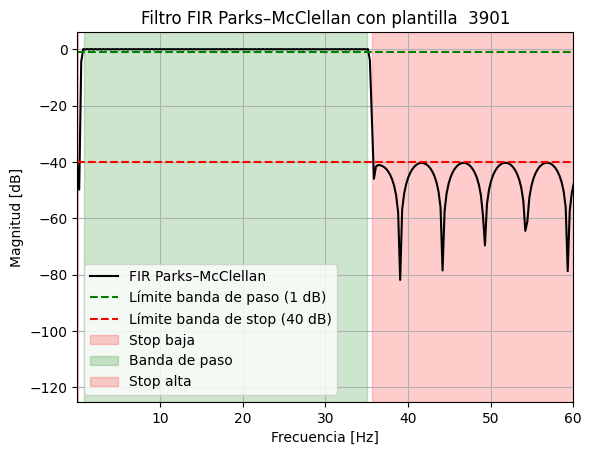

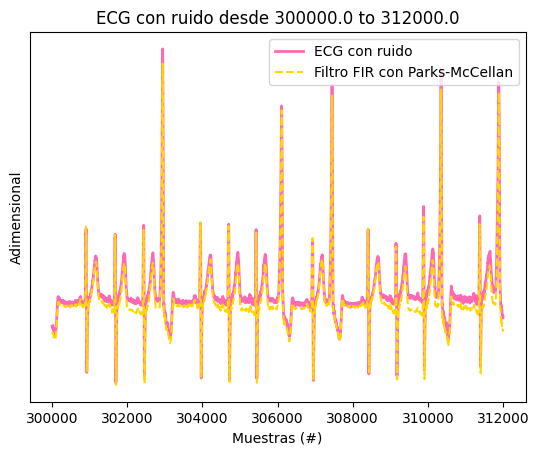

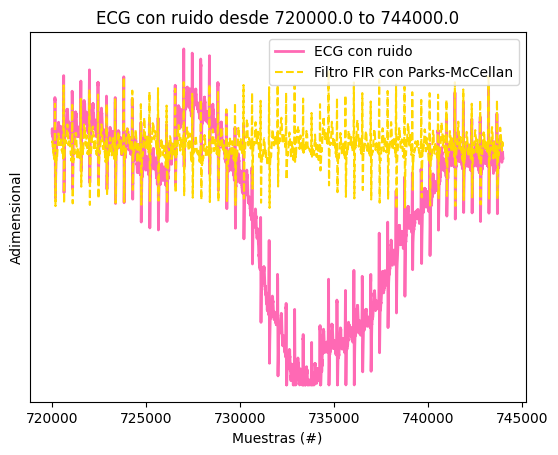

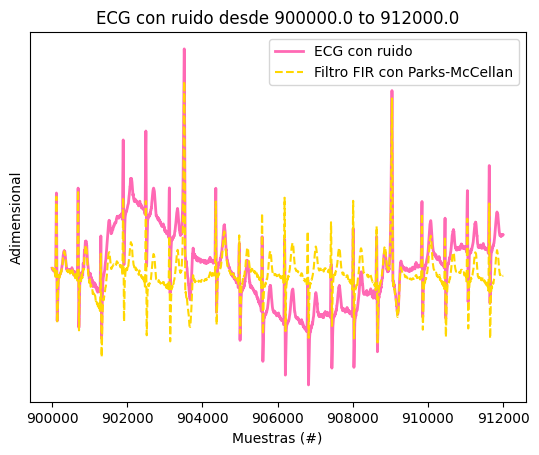

C:\Users\HP\AppData\Local\Temp\ipykernel_3180\2261436174.py:12: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(np.real(z), np.imag(z),


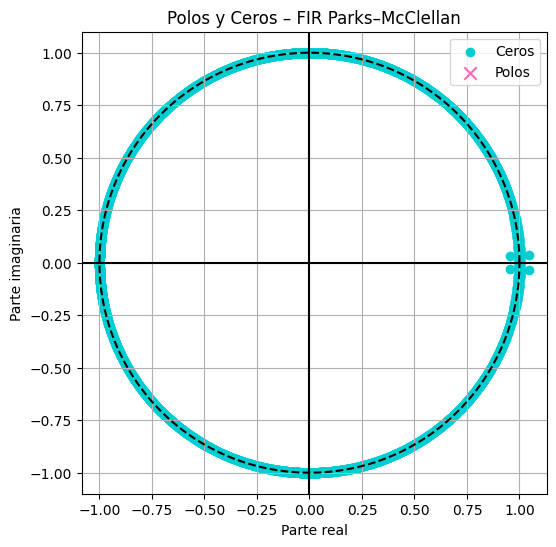

In [41]:
desired_pm = [0, 1, 0]
numtaps_pm = 3901

fir_pm = sig.remez(numtaps=numtaps_pm, bands=frecs, desired= desired_pm, weight=None, fs=fs_ecg)

# Respuesta en frecuencia
w_pm, h_pm = sig.freqz(fir_pm, worN=2048, fs=fs_ecg)

# --- Gráfico Bode + plantilla ---
plt.figure()
plt.plot(w_pm, 20 * np.log10(np.abs(h_pm)), color="black", label='FIR Parks–McClellan')
plt.axhline(-ripple, color='green', linestyle='--', label=f'Límite banda de paso ({ripple} dB)')
plt.axhline(-atenuacion, color='red', linestyle='--', label=f'Límite banda de stop ({atenuacion} dB)')

plt.axvspan(0, ws1, color='red', alpha=0.2, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.2, label='Banda de paso')
plt.axvspan(ws2, fs_ecg / 2.0, color='red', alpha=0.2, label='Stop alta')

plt.title(f'Filtro FIR Parks–McClellan con plantilla  {numtaps_pm}')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0.01, 60)
plt.grid(which='both')
plt.legend()
plt.show()

ecg_fir_pm = sig.lfilter(fir_pm, 1, ecgR_one_lead) # Aplico el filtro

# Retardo
retardo_fir_pm = (len(fir_pm) - 1)//2

for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecgR_one_lead[zoom_region], label='ECG con ruido', linewidth=2, color= 'hotpink')
    plt.plot(zoom_region, ecg_fir_pm[zoom_region + retardo_fir_pm], label='Filtro FIR con Parks-McCellan', linestyle='--', color= 'gold')
  
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

pzmap_fir(fir_pm, "Polos y Ceros – FIR Parks–McClellan")   

### Conclusiones

El análisis espectral (PSD) de la señal ECG permitió identificar las regiones en las que hay mucho ruido, tanto para altas como bajas frecuencias. A partir de ello se pudo diseñar una plantilla adecuada para los filtros. Luego se diseñaron e implementaron distintos tipos de filtros tanto IIR como FIR.

Los primeros demostraron una gran eficacia utilizando un orden menor que los filtros FIR. Esta característica los vuelve ideales cuando se requiere un filtro más simple, es decir, con menor costo computacional. Sin embargo, debido a su fase no lineal, resulta necesario aplicar un filtrado bidireccional con el objetivo de eliminar el retardo y poder así conservar la forma de la señal filtrada deseada.

Al comparar los diagramas de bode superpuestos con la plantilla se observó que los filtros que presentan ripple (Chebyshev tipo II y Cauer) tienen transiciones más abruptas y requieren de menor orden respecto a los otros. Por el contrario, el filtro Butterworth tiene la respuesta más suave pero a costa de un orden mayor.

Por otra parte, los filtros FIR también lograron satisfacer la plantilla propuesta aunque requirieron de un orden considerablemente mayor. Ya que estos filtros presentan una fase lineal, el retardo es constante y debe ser tenido en cuenta al analizar la señal filtrada.  Además, al no ser recursivos, se caracterizan por ser siempre estables. Esto se puede observar en los diagramas de polos y ceros ya que todos los ceros se encuentran sobre la circuinferencia unitaria. 

Para poder obtener la respuesta en frecuencia deseada fue necesario pre distorsionar la plantilla, volviéndola más exigente de lo esperado realmente. De esta forma se compensan las limitaciones del diseño asegurando que, aunque el filtro no cumpliera con la plantilla distorsionada sí lo haga con la deseada.

En el diseño de filtros FIR también se utilizaron distintos métodos. El primero fue el método de ventanas para el cual se eligió la ventana rectangular ya que es la que transiciona más rápido. Esto permite aproximarse a la plantilla con un orden menor que si se hubiesen usado otras ventanas.

El método de cuadrados mínimos busca minimizar el error cuadrático. Presenta un mayor ripple en la banda de stop y una transición más lenta.

Por último, el método de Parks McCellan se caracteriza por presentar equiripple en su respuesta en frecuencia. Este tipo de filtro FIR es el que mejor se adapta a la plantilla pero a costa de un orden mayor. 

Finalmente, se puede concluir que la elección de un tipo de filtrado implica un compromiso que dependerá de nuestro objetivo. Los filtros IIR serán la mejor opción cuando se requiere de un filtro de bajo costo computacional, pero aceptando que deberemos aplicar un filtro bidireccional, mientras que los FIR resultan más adecuados cuando se quiere tener un sistema más estable a costa de requerir un orden mucho mayor.